In [2]:
import shutil

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, box

import whisper
import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
from tqdm import tqdm

from data import BirdClefDataset
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(42)

In [20]:
# copy training data to subsample/ directory
shutil.copy("../data/birdclef-2024/train_metadata.csv", "./subsample/original_train_metadata.csv")
shutil.copy("../data/birdclef-2024/eBird_taxonomy_v2021.csv", "./subsample/eBird_taxonomy_v2021.csv")

'./subsample/eBird_taxonomy_v2021.csv'

In [21]:
training_data = gpd.read_file("./subsample/original_train_metadata.csv")

df = training_data.copy()
# drop rows with empty latitude or longitude
df = df[df['latitude'] != '']
df = df[df['longitude'] != '']

# cast to float
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

In [22]:
# Keep in the order provided by eBird!!!!
df_classes = pd.read_csv("./subsample/eBird_taxonomy_v2021.csv")
cls2idx = {cls: i for i, cls in enumerate(df_classes['SPECIES_CODE'])}

In [23]:
df['geometry'] = df.apply(lambda x: Point(x["longitude"], x["latitude"]), axis=1)
df = gpd.GeoDataFrame(df, geometry="geometry")
df.set_crs(epsg=4326, inplace=True)

df.head()


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,POINT (118.1987 39.2297)
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,POINT (104.6401 51.403)
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,POINT (127.3555 36.3319)
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,POINT (70.6005 21.1697)
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,POINT (73.7733 15.5442)


In [24]:
gb_bbox = box(-19.34,49.06,6.074,62.08)


In [25]:
gb_training_data = df[df.geometry.within(gb_bbox)]

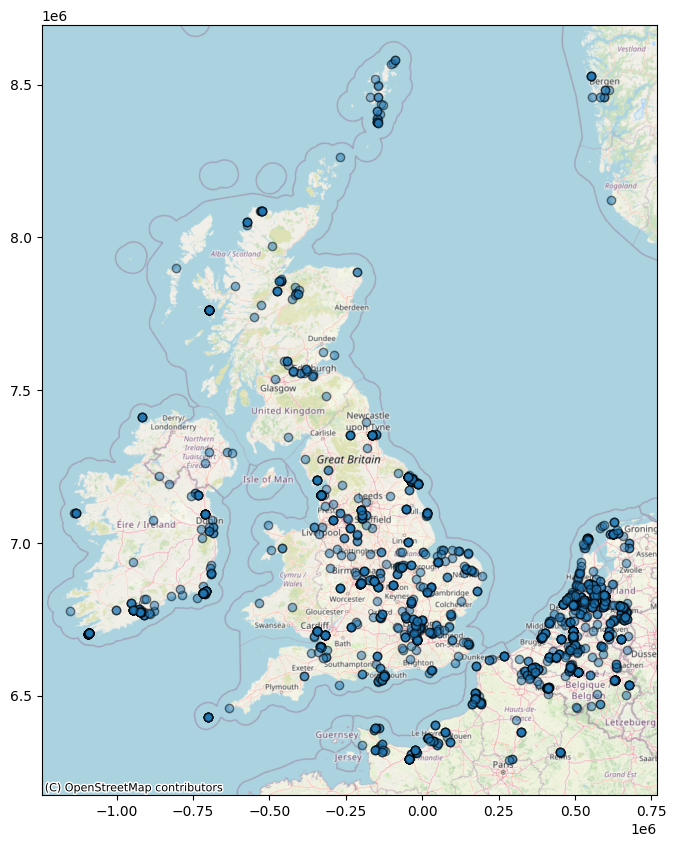

In [26]:
# visualize with basemap
ax = gb_training_data.to_crs(epsg=3857).plot(figsize=(10,10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()



## Example 2 : A small sample of audio files

10 species, 10 examples each
- take 10 species
- for each species, take 10 clips
- classify with our classifier
- train a new classifier on the new data
- test on unseen clips from the same species

## Classification
We have now hijacked the Whisper encoder to produce an encoded representation of the audio clip. 

There are a few ways to do this — I'm curious to see how they compare.

In [27]:
# Mean Pooling
class WhisperClassifier(torch.nn.Module):
    def __init__(self, whisper_encoder, num_classes):
        super().__init__()
        self.encoder = whisper_encoder
        self.classifier = nn.Linear(whisper_encoder.positional_embedding.size(-1), num_classes)
    
    def forward(self, mel_input):
        encoder_output = self.encoder(mel_input)
        pooled_features = encoder_output.mean(dim=1)
        logits = self.classifier(pooled_features)
        return logits

In [34]:
# Take top 10 most frequently-represented species
cls_train = gb_training_data.groupby('primary_label').size().sort_values(ascending=False)[0:10]

cls_train = cls_train.index.to_list()
cls2idx_sample = {cls: i for i, cls in enumerate(cls_train)}

In [35]:
df_sample_classes = df_classes[df_classes['SPECIES_CODE'].isin(cls_train)].reset_index(drop=True)

In [36]:
# If we need to regenerate the sample data, we can do so here:
# np.random.seed(42) # note that the data below was not generated with this seed
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()
# for cls in cls_train:
#     df_cls = gb_training_data[gb_training_data['primary_label'] == cls].sample(n=15)
#     df_train = pd.concat([df_train, df_cls[0:10]])
#     df_test = pd.concat([df_test, df_cls[10:15]])
# df_train.to_csv("./subsample/train_metadata.csv", index=False)
# df_test.to_csv("./subsample/test_metadata.csv", index=False)


In [37]:
# shuffle order
df_train = pd.read_csv("./subsample/train_metadata.csv")
df_test = pd.read_csv("./subsample/test_metadata.csv")



In [38]:
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,geometry
0,eurcoo,[],['call'],51.3672,5.8406,Fulica atra,Eurasian Coot,Ad Hilders,Creative Commons Attribution-NonCommercial-Sha...,3.0,http://xeno-canto.org/671670,eurcoo/XC671670.ogg,POINT (5.8406 51.3672)
1,eurcoo,[],"['begging call', 'juvenile']",51.4269,5.4752,Fulica atra,Eurasian Coot,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/573675,eurcoo/XC573675.ogg,POINT (5.4752 51.4269)
2,eurcoo,[],[''],54.1323,-0.1239,Fulica atra,Eurasian Coot,Mark Pearson,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/808756,eurcoo/XC808756.ogg,POINT (-0.1239 54.1323)
3,eurcoo,[],[''],52.6975,-0.5962,Fulica atra,Eurasian Coot,Andrew Harrop,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/819364,eurcoo/XC819364.ogg,POINT (-0.5962 52.6975)
4,eurcoo,[],['flight call'],51.9400,5.9038,Fulica atra,Eurasian Coot,Joost van Bruggen,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/384481,eurcoo/XC384481.ogg,POINT (5.9038 51.94)


In [39]:
# Confirm df_sample_classes are the same as in df_train
sorted(list(df_train['primary_label'].unique())) == sorted(cls_train)


True

In [44]:
# Not necessary on git repo, since we're including the audio files
# import shutil
# import os

# def copy_audio_files(df, dest_dir):    
#     for _, row in df.iterrows():
#         # check if it exists in target directory
#         if os.path.exists(f"{dest_dir}/{row['filename']}"):
#             print(f"File {row['filename']} already exists")
#             continue
#         # copy the file to a new location
#         # make sure the directory exists
#         subdir = row['filename'].split('/')[0]
#         os.makedirs(f"./{dest_dir}/{subdir}", exist_ok=True)
#         shutil.copy(f"../data/birdclef-2024/train_audio/{row['filename']}", f"{dest_dir}/{row['filename']}")

# copy_audio_files(df_train, "./subsample/train")
# copy_audio_files(df_test, "./subsample/test")


In [56]:
# hard reload birdclefdataset, local module

import importlib
import data
importlib.reload(data)
from data import BirdClefDataset

In [46]:
dataset_train = BirdClefDataset(df_train, "./subsample/train", df_sample_classes)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False)

In [47]:
model = whisper.load_model("small")
model.to(model.device)

/Users/x25bd/Code/mlx/week-7/mlx-whisper/.venv/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp,

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=False)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
        )
        (attn_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (mlp_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-0

In [48]:
classifier = WhisperClassifier(model.encoder, len(df_sample_classes))
classifier.to(model.device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()



In [51]:
wandb.init(project="mlx-whisper", name="train-classifier")
for epoch in tqdm(range(10), desc="Epochs"):
    for batch_idx, (mel_input, cls_actual, _) in tqdm(enumerate(dataloader_train), desc="Training", total=len(dataloader_train)):
        optimizer.zero_grad()

        mel_input = mel_input.to(model.device)
        cls_actual = cls_actual.to(model.device)

        logits = classifier(mel_input)
        
        loss = criterion(logits, cls_actual)
        # accuracy = torch.sum(torch.argmax(logits, dim=1) == cls_actual).item() / len(cls_actual)
        # Print stats of batch
        print(f"""====================
Epoch {epoch},Batch {batch_idx}
              """)
        print(f"Loss: {loss.item()}")
        # print(f"Accuracy: {accuracy}")

        
        wandb.log({"loss": loss.item()
                  # "accuracy": accuracy
                   })
        loss.backward()
        optimizer.step()

wandb.finish()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0,Batch 0
              
Loss: 2.080301523208618


Epoch 0,Batch 1
              
Loss: 10.523258209228516


Epoch 0,Batch 2
              
Loss: 4.9224419593811035


Epoch 0,Batch 3
              
Loss: 5.167433261871338


Epoch 0,Batch 4
              
Loss: 4.153460502624512


Epoch 0,Batch 5
              
Loss: 5.461974143981934


Epoch 0,Batch 6
              
Loss: 1.8045843839645386


Epochs:  10%|█         | 1/10 [07:25<1:06:53, 445.93s/it]

Epoch 1,Batch 0
              
Loss: 6.551239490509033


Epoch 1,Batch 1
              
Loss: 3.8628392219543457


Epoch 1,Batch 2
              
Loss: 8.833353996276855


Epoch 1,Batch 3
              
Loss: 8.04326343536377


Epoch 1,Batch 4
              
Loss: 6.913911819458008


Epoch 1,Batch 5
              
Loss: 2.66983699798584


Epoch 1,Batch 6
              
Loss: 2.165788412094116


Epochs:  20%|██        | 2/10 [15:47<1:03:49, 478.68s/it]

Epoch 2,Batch 0
              
Loss: 4.792483329772949


Epoch 2,Batch 1
              
Loss: 6.485560417175293


Epoch 2,Batch 2
              
Loss: 3.433730125427246


Epoch 2,Batch 3
              
Loss: 2.359858751296997


Epoch 2,Batch 4
              
Loss: 2.2460551261901855


Epoch 2,Batch 5
              
Loss: 3.424452781677246


Epoch 2,Batch 6
              
Loss: 3.6529417037963867


Epochs:  30%|███       | 3/10 [23:24<54:40, 468.62s/it]  

Epoch 3,Batch 0
              
Loss: 3.4594178199768066


Epoch 3,Batch 1
              
Loss: 5.034785270690918


Epoch 3,Batch 2
              
Loss: 2.4335601329803467


Epoch 3,Batch 3
              
Loss: 2.6039481163024902


Epoch 3,Batch 4
              
Loss: 2.672992467880249


Epoch 3,Batch 5
              
Loss: 2.608295202255249


Epoch 3,Batch 6
              
Loss: 1.8580231666564941


Epochs:  40%|████      | 4/10 [32:02<48:50, 488.35s/it]

Epoch 4,Batch 0
              
Loss: 2.4876914024353027


Epoch 4,Batch 1
              
Loss: 3.4488043785095215


Epoch 4,Batch 2
              
Loss: 3.049513578414917


Epoch 4,Batch 3
              
Loss: 3.085949420928955


Epoch 4,Batch 4
              
Loss: 3.19008469581604


Epoch 4,Batch 5
              
Loss: 2.1332788467407227


Epoch 4,Batch 6
              
Loss: 2.0412890911102295


Epochs:  50%|█████     | 5/10 [39:29<39:27, 473.52s/it]

Epoch 5,Batch 0
              
Loss: 2.83589243888855


Epoch 5,Batch 1
              
Loss: 2.3953981399536133


Epoch 5,Batch 2
              
Loss: 2.782618761062622


Epoch 5,Batch 3
              
Loss: 2.5501163005828857


Epoch 5,Batch 4
              
Loss: 2.4745121002197266


Epoch 5,Batch 5
              
Loss: 2.4995288848876953


Epoch 5,Batch 6
              
Loss: 2.173264980316162


Epochs:  60%|██████    | 6/10 [47:50<32:10, 482.54s/it]

Epoch 6,Batch 0
              
Loss: 2.7800121307373047


Epoch 6,Batch 1
              
Loss: 2.748134136199951


Epoch 6,Batch 2
              
Loss: 2.672794818878174


Epoch 6,Batch 3
              
Loss: 2.545708179473877


Epoch 6,Batch 4
              
Loss: 2.4899609088897705


Epoch 6,Batch 5
              
Loss: 2.3973114490509033


Epoch 6,Batch 6
              
Loss: 1.720860481262207


Epochs:  70%|███████   | 7/10 [56:06<24:21, 487.11s/it]

Epoch 7,Batch 0
              
Loss: 2.678698778152466


Epoch 7,Batch 1
              
Loss: 2.8230788707733154


Epoch 7,Batch 2
              
Loss: 2.657822608947754


Epoch 7,Batch 3
              
Loss: 2.6640162467956543


Epoch 7,Batch 4
              
Loss: 2.682774543762207


Epoch 7,Batch 5
              
Loss: 2.2396609783172607


Epoch 7,Batch 6
              
Loss: 1.9263300895690918


Epochs:  80%|████████  | 8/10 [1:05:41<17:10, 515.12s/it]

Epoch 8,Batch 0
              
Loss: 2.564239263534546


Epoch 8,Batch 1
              
Loss: 2.546325445175171


Epoch 8,Batch 2
              
Loss: 2.689359188079834


Epoch 8,Batch 3
              
Loss: 2.637225389480591


Epoch 8,Batch 4
              
Loss: 2.6068804264068604


Epoch 8,Batch 5
              
Loss: 2.2930870056152344


Epoch 8,Batch 6
              
Loss: 1.968273401260376


Epochs:  90%|█████████ | 9/10 [1:17:45<09:40, 580.24s/it]

Epoch 9,Batch 0
              
Loss: 2.6234395503997803


Epoch 9,Batch 1
              
Loss: 2.548178195953369


Epoch 9,Batch 2
              
Loss: 2.696035861968994


Epoch 9,Batch 3
              
Loss: 2.5957841873168945


Epoch 9,Batch 4
              
Loss: 2.477623224258423


Epoch 9,Batch 5
              
Loss: 2.3158698081970215


Epoch 9,Batch 6
              
Loss: 1.8221917152404785


Epochs: 100%|██████████| 10/10 [1:29:06<00:00, 534.64s/it]


loss,▄▄▅▁▆█▇▂▁▄▁▃▃▃▅▂▂▁▂▂▁▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁
loss,1.82219


In [57]:
dataset_test = BirdClefDataset(df_test, "./subsample", df_sample_classes, "test")
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [64]:
model.eval()
for batch_idx, (mel_input, cls_actual, _) in tqdm(enumerate(dataloader_test), desc="Testing", total=len(dataloader_test)):
    mel_input = mel_input.to(model.device)
    cls_actual = cls_actual.to(model.device)

    logits = classifier(mel_input)
    loss = criterion(logits, cls_actual)
    predicted_idx = torch.argmax(logits, dim=1).item()
    actual_idx = torch.argmax(cls_actual, dim=1).item()
    predicted = df_sample_classes.iloc[predicted_idx]
    actual = df_sample_classes.iloc[actual_idx]
    print(f"""
====================
          Predicted: {predicted['SPECIES_CODE']} ({predicted['PRIMARY_COM_NAME']})
          Actual: {actual['SPECIES_CODE']} ({actual['PRIMARY_COM_NAME']})
          Loss: {loss.item()}
""")


Testing:   2%|▏         | 1/50 [00:01<01:10,  1.44s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.7820701599121094



Testing:   4%|▍         | 2/50 [00:02<01:03,  1.33s/it]


          Predicted: rorpar (Rose-ringed Parakeet)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.648545980453491



Testing:   6%|▌         | 3/50 [00:03<00:58,  1.24s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.7021822929382324



Testing:   8%|▊         | 4/50 [00:04<00:55,  1.21s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.762953281402588



Testing:  10%|█         | 5/50 [00:06<00:52,  1.17s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: eurcoo (Eurasian Coot)
          Loss: 2.682920455932617



Testing:  12%|█▏        | 6/50 [00:07<00:51,  1.17s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.3529767990112305



Testing:  14%|█▍        | 7/50 [00:09<01:02,  1.45s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.7288403511047363



Testing:  16%|█▌        | 8/50 [00:10<00:57,  1.38s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.7476396560668945



Testing:  18%|█▊        | 9/50 [00:11<00:55,  1.35s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.7691705226898193



Testing:  20%|██        | 10/50 [00:12<00:51,  1.30s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: commoo3 (Eurasian Moorhen)
          Loss: 2.562920331954956



Testing:  22%|██▏       | 11/50 [00:14<00:48,  1.23s/it]


          Predicted: rorpar (Rose-ringed Parakeet)
          Actual: litgre1 (Little Grebe)
          Loss: 2.638373851776123



Testing:  24%|██▍       | 12/50 [00:15<00:45,  1.20s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: litgre1 (Little Grebe)
          Loss: 2.5470004081726074



Testing:  26%|██▌       | 13/50 [00:16<00:43,  1.18s/it]


          Predicted: eucdov (Eurasian Collared-Dove)
          Actual: litgre1 (Little Grebe)
          Loss: 2.5818405151367188



Testing:  28%|██▊       | 14/50 [00:17<00:42,  1.17s/it]


          Predicted: rorpar (Rose-ringed Parakeet)
          Actual: litgre1 (Little Grebe)
          Loss: 2.564898729324341



Testing:  28%|██▊       | 14/50 [00:17<00:46,  1.28s/it]


KeyboardInterrupt: 